In [37]:
import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation
from lstmPrice_Prediction import PricePrediction
import warnings
warnings.filterwarnings("ignore")

### Load in Data and Clean:

In [39]:
# Load historical data from file:
df = pd.read_csv('eth_historical_data.csv')

# Convert timezones and reformat:
df['time_period_start'] = pd.to_datetime(df['time_period_start']).dt.tz_convert('US/Central').dt.strftime('%m-%d-%Y %H:%M')
# Reset Index
df.set_index('time_period_start', inplace=True)
# Pull just the value fields:
df = df[['price_open', 'price_high', 'price_low', 'price_close']]
df.head()

,price_open,price_high,price_low,price_close
time_period_start,,,,
06-24-2019 17:00,308.84,313.09,308.84,311.24
06-24-2019 17:30,311.23,311.70,308.12,308.80
06-24-2019 18:00,308.89,310.31,308.24,308.91
06-24-2019 18:30,308.81,310.44,308.81,310.44
06-24-2019 19:00,310.75,312.40,309.79,310.43


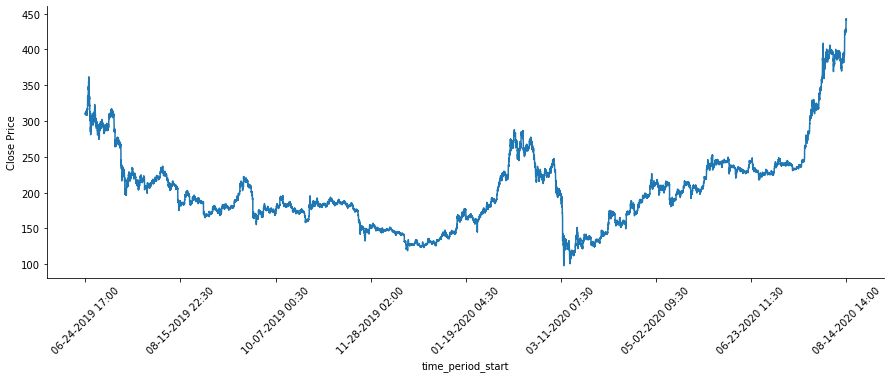

In [40]:
# Plot the closing prices just as a reference:
df['price_close'].plot(figsize=(15,5))
plt.ylabel('Close Price')
plt.xticks(rotation=45)
sns.despine()
plt.show()

### Prepare Data for Modeling

In [45]:
lstm = PricePrediction()
lstm.load_dataframe(df)
train_set, test_set = lstm.split_data()

n_input = 10
n_out = 1

X_train, y_train = lstm.to_supervised_classification(train_set, n_input, n_out)
X_test, y_test = lstm.to_supervised_classification(test_set, n_input, n_out)

X_train_norm = lstm.normalize_x_only(X_train)
X_test_norm = lstm.normalize_x_only(X_test)

In [53]:
neurons = 1024               # number of hidden units in the LSTM layer
activation_function = 'sigmoid'  # activation function for LSTM and Dense layer
loss = 'binary_crossentropy'  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 12

def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=n_out))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
    model.summary()
    return model

In [54]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
model = build_model(X_train_norm, n_out, neurons=neurons)
results = model.fit(X_train_norm, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_norm, y_test), shuffle=False)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 10, 1024)          4214784   
_________________________________________________________________
dropout_28 (Dropout)         (None, 10, 1024)          0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 10, 1024)          8392704   
_________________________________________________________________
dropout_29 (Dropout)         (None, 10, 1024)          0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 10, 1024)          8392704   
_________________________________________________________________
dropout_30 (Dropout)         (None, 10, 1024)          0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 1024)             

KeyboardInterrupt: 

### Prediction Analysis